# Lecture 2 - Quantum Rabi Model
### This notebook had originally been created for the CECAM Ab Initio QEDFT school (2024) by Simone Latini. Minor modifications have been made by Dominik Sidler for the polaritonic / QED chemistry lecture.  
-------------
A polariton is a light-matter quasi-particle made of a material and a photon-field excitation. Here we will consider exciton polaritons as a prototypical example.

The simplest version of a Hamiltonian describing an exciton polariton of a single excitonic transition coupled to a single photonic mode can be  written as:

$$
\hat{H}_{\text{pol}} = \Delta |e\rangle \langle e| + \underbrace{\frac{\hbar^{1/2}\omega_{\textrm{d}}}{\sqrt{2 m \omega}}}_{=A_0 ~\textrm{(in a.u.)}} \left( \langle gs|\hat{\epsilon} \cdot  \hat{p} | e \rangle |gs\rangle \langle e|~\hat{a}^\dagger + \langle e|\hat{\epsilon} \cdot  \hat{p} | gs \rangle |e\rangle \langle gs|~\hat{a}\right) + \underbrace{\frac{\hbar \omega_{\mathrm{d}}^2}{4 m \omega}}_{=\frac{1}{2}A_0^2 } \left( \hat{a} + \hat{a}^{\dagger} \right)^2 + \hbar \omega \left(\hat{a}^\dagger \hat{a} + \frac{1}{2} \right),
$$

with $\hat{p} = -i \partial_x$, $|0\rangle,|e\rangle$ the groundstate and the lowest electronic state respectively and $\Delta$ the gap. Remember $\omega_{\text{d}} = \sqrt{\frac{e^2 N_e}{m \epsilon_0 L^3}}$ and that we consider $N_{\mathrm{e}}=1$. 
#### The quantum Rabi model is equivalent to the Jaynes-Cummings model without rotating wave approximation.

## Q. 2
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
Let's use python to diagonalize the problem numerically in a tensor product basis of the kind

$$
\{|gs\rangle, |e\rangle\}\otimes\{|n\rangle\}_{n \in \mathcal{I}},
$$

where $\mathcal{I} =\{0, \dots, n_{ph}\}$ the set of explicitly conidered field excitations/number of photons. To build the Hamiltonian and diagonalize the Hamiltonian you can use the function below (what are the functions doing and what are the variables that they take in?). What is the difference to the RWA assumption in the Jaynes-Cummings model?

<details>
<summary>Hint</summary>
The matrix should look like this

$$
\begin{array}{c|ccccccc}
& \ket{gs, 0} & \ket{e, 0} & \ket{gs, 1} & \ket{e, 1} & \ket{gs, 2} & \ket{e, 2} \\
\hline
\bra{gs, 0} & \frac{1}{2}(\omega_c + A_0^2) & 0 & 0 & A_0 P_{0,e} & \frac{\sqrt{2}}{2} A_0^2 & 0 \\
\bra{e, 0} & 0 & \Delta + \frac{1}{2}(\omega_c + A_0^2) & A_0 P_{e, 0} & 0 & 0 & \frac{\sqrt{2}}{2} A_0^2 \\
\bra{gs, 1} & 0 & A_0 P_{0,e} &  \frac{3}{2}(\omega_c + A_0^2) & 0 & 0 & \sqrt{2} A_0 P_{0,e} \\
\bra{e, 1} & A_0 P_{e,0} & 0 & 0 & \Delta + \frac{3}{2}(\omega_c + A_0^2) & \sqrt{2} A_0 P_{e, 0} & 0 \\
\bra{gs, 2} & \frac{\sqrt{2}}{2} A_0^2 & 0 & 0 & \sqrt{2} A_0 P_{0,e} & \frac{5}{2}(\omega_c + A_0^2) & 0 \\
\bra{e, 2} & 0 & \frac{\sqrt{2}}{2} A_0^2 & \sqrt{2} A_0 P_{e, 0} & 0 & 0 & \Delta + \frac{5}{2}(\omega_c + A_0^2)\\
\end{array}
$$

</details>

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg

# Build polariton Hamiltonian
def build_Hpol(H_mat, wc, nph, p_mat, A_0):
    # H_mat: Matter Hamiltonian
    # wc: cavity frequency
    # nph: number of photons
    # p_mat: momentum operator in the matter basis
    # A_0: mode strength

    # ---------------------
    # Light-Matter Diagonal
    # ---------------------
    e_tol = 1e-9
    # Matter
    H_pol_mat_d = np.kron(np.eye(nph), H_mat)

    # Photons (diagonal a^dagger a contributions)
    H_ph_d = (np.diag(np.arange(0., nph*wc-e_tol, wc) + 0.5*wc) +
            1./2. * np.diag(2.*np.arange(0., nph*A_0**2-e_tol, A_0**2) + A_0**2))
    H_pol_ph_d = np.kron(H_ph_d, np.eye(H_mat.shape[0]))

    # ----------------------
    # A^2 term off-diagonal
    # ----------------------
    # sqrt(n+1) factors from the application of the bosonic operator
    n_quad = (np.sqrt(np.arange(0, nph-2, 1) + 1) * np.sqrt(np.arange(0, nph-2, 1) + 2))
    M_quad = np.diag(n_quad, k=2)

    H_A2 = 0.5 * np.kron(M_quad, np.eye(H_mat.shape[0]))
    H_A2 += np.transpose(H_A2).conj()

    # ----------
    # P.A term
    # ----------
    # sqrt(n+1) factors from the application of the bosonic operator
    n_sqrt = np.sqrt(np.arange(0, nph-1, 1) + 1)
    M_sqrt = np.diag(n_sqrt, k=1)

    H_PA = np.kron(M_sqrt, p_mat)
    H_PA += H_PA.T.conj()

    # -----------------
    # Full Hamiltonian
    # -----------------
    H_pol = H_pol_mat_d + H_pol_ph_d + A_0 * H_PA + A_0**2 * H_A2
    return H_pol

def diagonalize_H(H_pol, n_eig=10, sparse=False):
    if not sparse:
        ev_N, es_MN = np.linalg.eig(H_pol)
    else:
        H_sparse = sp.csr_matrix(H_pol)
        ev_N, es_MN = sp_linalg.eigs(H_sparse, k=n_eig, which='SM', tol=1e-7)
    sort_N = np.argsort(ev_N)
    ev_N = ev_N[sort_N]
    es_MN = es_MN[:, sort_N]

    return np.array(ev_N), np.array(es_MN)

## A. 2
-------------
We should use the functions above to first build the Hamiltonian and then diagonalize it. After that we plot the eigenvalues (after sorting, to avoid weird jumps in the plotting). Notice that the offdiagonal matrix elements of the $\hat{A}^2$ supress the blockdiagonal character of the JC-model. Thus for strong coupling, we need to increase the photon number basis set size $n_{ph}$ to converge to an accurate numerical solution for the quantum Rabi model.

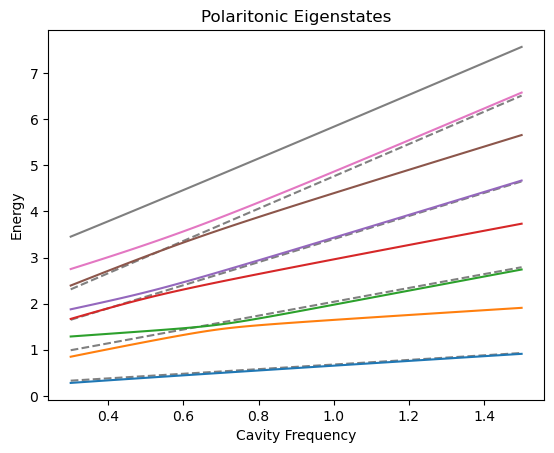

In [6]:
import matplotlib.pyplot as plt
E_exc = 1. # excitation energy of bare matter
H_mat = np.array([[0., 0.],[0., E_exc]])
wc = np.linspace(0.3, 1.5, 100)
nph = 4
p_mat = 0.1*np.array([[0., 1.],[1., 0]])
A_0 = 0.6

# Plot the first 5 eigenvalues as a function of frequency
#n_sel = 5
ev_sel = []
for w in wc:
    H = build_Hpol(H_mat=H_mat, wc=w, nph=nph, p_mat=p_mat, A_0=A_0)
    ev, es = diagonalize_H(H)
    ev_sel.append(ev)


# Photon lines as guide for the eye
n_l = nph-1
ph_l = []
for l in range(n_l+1):
    y_l = (l + 0.5)*(wc + A_0**2)
    plt.plot(wc, y_l, ls='--', c='gray')

plt.plot(wc, ev_sel)

plt.xlabel('Cavity Frequency')
plt.ylabel('Energy')
plt.title('Polaritonic Eigenstates')
plt.show()